# LaiData Spark Final Project

## Background
<br>Collaborative Filtering(CF) is a subset of algorithms that exploit other users and items along with their ratings(selection, purchase information could be also used) and target user history to recommend an item that target user does not have ratings for. Fundamental assumption behind this approach is that other users preference over the items could be used recommending an item to the user who did not see the item or purchase before.  <br/>
<br>Spark does not include an implementation for user-based or item-based collaborative filtering. Instead, it has the Alternating Least Squares (ALS) Matrix Factorization method. ALS works by trying to find the optimal representation of a user and a product matrix – which when combined, should accurately represent the original dataset. The genius part of ALS is that it alternates between finding the optimal values for the user matrix and the product matrix.<br/>

## Algorithm
<br> The basic idea of matrix factorization is that, each user can be described by k attributes or features, and each item can be described by an analagous set of k attributes or features. If we multiply each feature of the user by the correspoinding feature of the movie and add everything together, this will be a good approximation for the rating the user would give the movie. In formula,<br/>

$$R_{ui} = X_u^T * Y_i = \sum_k x_{uk}*y_{ki} $$

<br>where $R_{ui}$ is our prediction for the true rating, and $X_u^T$ and $Y_i$ are assumed to be a row (column) vector, which represents the user and item latent vectors. And the lost function for this model is<br/>

$$ L = \sum_{u,i}(r_{ui} - X_u^T * Y_i)^2 + \lambda_x \sum_u ||X_u||^2 + \lambda_y \sum_u ||Y_i||^2$$

<br>To find the optimal solutions for this lost function, we use Alternating Least Squares, which assume one variable is computed, and use the computed value for other one. We find the derivative of the function first, with respect to two variables, $X_u$ and $Y_i$, and set it as zero. Fortunately, we can find the closed form solution for both variables<br/>

$$X_u^T = r_uY(Y^TY+\lambda_xI)^{-1}$$
$$Y_i = r_uX^T(XX^T+\lambda_yI)^{-1}$$

## Codes: Python Part

### Data Exploration

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from numpy.linalg import solve
%matplotlib inline

In [2]:
link = pd.read_csv('ml-latest-small/links.csv')
link.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [3]:
movie = pd.read_csv('ml-latest-small/movies.csv')
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
rate = pd.read_csv('ml-latest-small/ratings.csv')
rate.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
tag = pd.read_csv('ml-latest-small/tags.csv')
tag.head()

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765


### Rating matrix building
<br>For the rating matrix, I constructed it as followed rule. But I am not exactly sure I should rate 0 for the missing values, cause 0 means user do not like the item in some sense. But I don't have a better idea to fill the missing values, so I still do it in this way.<br/>

$$ R_{ui}=\left\{
\begin{aligned}
r\text{,  if user u rate item i} \\
0\text{,  if user u did not rate item i}
\end{aligned}
\right.
$$

In [11]:
table = pd.pivot_table(rate,index = 'userId',columns = 'movieId',values = 'rating')
rating = table.fillna(value = 0).as_matrix()
rating

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 5.,  0.,  0., ...,  0.,  0.,  0.]])

In [31]:
rating.shape

(671, 9066)

### My ALS

In [66]:
def myALS(lambda_, n_factors, ratings, n_iter):
    m, n = ratings.shape
    X = 5 * np.random.rand(m, n_factors) 
    Y = 5 * np.random.rand(n_factors, n)
    mse = []
    
    def get_mse(Q, X, Y):
        return np.square(Q - np.dot(X, Y)).mean()
    
    for ii in range(n_iterations):
        X = np.linalg.solve(np.dot(Y, Y.T) + lambda_ * np.eye(n_factors), 
                            np.dot(Y, ratings.T)).T
        Y = np.linalg.solve(np.dot(X.T, X) + lambda_ * np.eye(n_factors),
                            np.dot(X.T, ratings))
        if ii % 5 == 0:
            new_mse = get_mse(ratings, X, Y)
            mse.append(new_mse)
            print('{}th iteration'.format(ii))
            print('Train mse:' + str(new_mse))
    ratings_hat = np.dot(X,Y)
    plt.plot(mse)

0th iteration
Train mse:0.187440186664
5th iteration
Train mse:0.0992529467734
10th iteration
Train mse:0.0985339315973
15th iteration
Train mse:0.0983438396054
20th iteration
Train mse:0.0982628085261
25th iteration
Train mse:0.0982222301716
30th iteration
Train mse:0.0982005645736


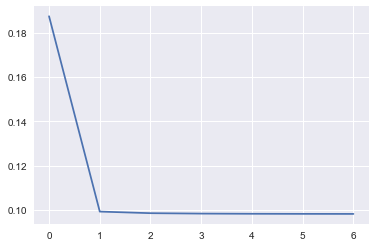

In [67]:
lambda_ = 0.1
n_factors = 50
n_iterations = 31

myALS(lambda_, n_factors, rating, n_iterations)

### ALS from class

In [63]:
class ExplicitMF():
    def __init__(self,
                ratings,
                n_factors = 40,
                item_reg = 0.0,
                user_reg = 0.0,
                verbose = False):
        self.ratings = ratings
        self.n_users,self.n_items = rating.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose
        
    def als_step(self,
                latent_vectors,
                fixed_vecs,
                ratings,
                _lambda,
                type = 'user'):
        if type == 'user':
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda
            
            for u in range(latent_vectors.shape[0]):
                latent_vectors[u,:] = solve((YTY + lambdaI),
                                           rating[u,:].dot(fixed_vecs))
        elif type == 'item':
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i,:] = solve((XTX + lambdaI),
                                           rating[:,i].T.dot(fixed_vecs))
        return latent_vectors
    
    def train(self,n_iter = 10):
        self.user_vecs = np.random.random((self.n_users,self.n_factors))
        self.item_vecs = np.random.random((self.n_items,self.n_factors))
        
        self.partial_train(n_iter)
        
    def partial_train(self,n_iter):
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration:{}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs,
                                          self.item_vecs,
                                          self.ratings,
                                          self.user_reg,
                                          type = 'user')
            self.item_vecs = self.als_step(self.item_vecs,
                                          self.user_vecs,
                                          self.ratings,
                                          self.user_reg,
                                          type = 'item')
            ctr += 1
    
    def predict_all(self):
        predictions = np.zeros((self.user_vecs.shape[0],
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u,i] = self.predict(u,i)
                
        return predictions
    
    def predict(self,u,i):
        return self.user_vecs[u,:].dot(self.item_vecs[i,:].T)
    
    def get_mse(self,pred,y):
        return np.square(pred - y).mean()
    
    def calculate_learning_curve(self,iter_array):
        iter_array.sort()
        self.train_mse = []
        #self.test_mse = []
        iter_diff = 0
        for (i,n_iter) in enumerate(iter_array):
            if self._v:
                print('Iteration:{}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)
                
            predictions = self.predict_all()
            
            self.train_mse += [self.get_mse(predictions, self.ratings)]
            #self.test_mse += [self.get_mse(predictions, test)]
            if self._v:
                print('Train mse:' + str(self.train_mse[-1]))
                #print('Test mse:' + str(self.test_mse[-1]))
            iter_diff = n_iter
        plt.plot(self.train_mse)

Iteration:1
Train mse:0.145579147091
Iteration:6
Train mse:0.0994284457374
Iteration:11
Train mse:0.0985307004103
Iteration:16
Train mse:0.0983258252223
Iteration:21
Train mse:0.0982545816915
Iteration:26
Train mse:0.0982224854597


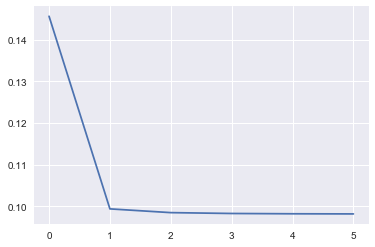

In [64]:
ExplicitMF(ratings = rating,
            n_factors = 50,
            item_reg = 0.2,
            user_reg = 0.2,
            verbose = True).calculate_learning_curve(np.arange(1,31,5))

### Conclusion

<br>It looks like both codes work well, and they provided similar results. About 10 iterations, the error tend to converge to a steady point and it can rarely reduce anymore.<br/>

## Codes: Spark Part

### Data Exploration

In [1]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext()

from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Python Spark SQL basic example").config("spark.some.config.option","some-value").getOrCreate()

In [8]:
link_sc = sc.textFile('ml-latest-small/links.csv').map(lambda line:line.split(","))
header = link_sc.first()
link_sc = link_sc.filter(lambda row: row != header)
l = link_sc.map(lambda p: Row(movieId = p[0], imdbId = p[1], tmdbId = p[2]))
schemalink = spark.createDataFrame(l)
schemalink.createOrReplaceTempView('link')

In [7]:
spark.sql("select * from link").show()

+-------+-------+------+
| imdbId|movieId|tmdbId|
+-------+-------+------+
|0114709|      1|   862|
|0113497|      2|  8844|
|0113228|      3| 15602|
|0114885|      4| 31357|
|0113041|      5| 11862|
|0113277|      6|   949|
|0114319|      7| 11860|
|0112302|      8| 45325|
|0114576|      9|  9091|
|0113189|     10|   710|
|0112346|     11|  9087|
|0112896|     12| 12110|
|0112453|     13| 21032|
|0113987|     14| 10858|
|0112760|     15|  1408|
|0112641|     16|   524|
|0114388|     17|  4584|
|0113101|     18|     5|
|0112281|     19|  9273|
|0113845|     20| 11517|
+-------+-------+------+
only showing top 20 rows



In [5]:
movie_sc = sc.textFile('ml-latest-small/movies.csv').map(lambda line:line.split(","))
header = movie_sc.first()
movie_sc = movie_sc.filter(lambda row: row != header)
m = movie_sc.map(lambda p: Row(movieId = p[0], title = p[1], genres = p[2]))
schemamovie = spark.createDataFrame(m)
schemamovie.createOrReplaceTempView('movie')

In [11]:
spark.sql("select * from movie").show()

+--------------------+-------+--------------------+
|              genres|movieId|               title|
+--------------------+-------+--------------------+
|Adventure|Animati...|      1|    Toy Story (1995)|
|Adventure|Childre...|      2|      Jumanji (1995)|
|      Comedy|Romance|      3|Grumpier Old Men ...|
|Comedy|Drama|Romance|      4|Waiting to Exhale...|
|              Comedy|      5|Father of the Bri...|
|Action|Crime|Thri...|      6|         Heat (1995)|
|      Comedy|Romance|      7|      Sabrina (1995)|
|  Adventure|Children|      8| Tom and Huck (1995)|
|              Action|      9| Sudden Death (1995)|
|Action|Adventure|...|     10|    GoldenEye (1995)|
|         The (1995)"|     11| "American President|
|       Comedy|Horror|     12|Dracula: Dead and...|
|Adventure|Animati...|     13|        Balto (1995)|
|               Drama|     14|        Nixon (1995)|
|Action|Adventure|...|     15|Cutthroat Island ...|
|         Crime|Drama|     16|       Casino (1995)|
|       Dram

In [2]:
rate_sc = sc.textFile('ml-latest-small/ratings.csv').map(lambda line:line.split(","))
header = rate_sc.first()
rate_sc = rate_sc.filter(lambda row: row != header)
r = rate_sc.map(lambda p: Row(userId = p[0], movieId = p[1], rating = p[2], timestamp = p[3]))
schemarate = spark.createDataFrame(r)
schemarate.createOrReplaceTempView('rating')

In [10]:
spark.sql("select * from rating").show()

+-------+------+----------+------+
|movieId|rating| timestamp|userId|
+-------+------+----------+------+
|     31|   2.5|1260759144|     1|
|   1029|   3.0|1260759179|     1|
|   1061|   3.0|1260759182|     1|
|   1129|   2.0|1260759185|     1|
|   1172|   4.0|1260759205|     1|
|   1263|   2.0|1260759151|     1|
|   1287|   2.0|1260759187|     1|
|   1293|   2.0|1260759148|     1|
|   1339|   3.5|1260759125|     1|
|   1343|   2.0|1260759131|     1|
|   1371|   2.5|1260759135|     1|
|   1405|   1.0|1260759203|     1|
|   1953|   4.0|1260759191|     1|
|   2105|   4.0|1260759139|     1|
|   2150|   3.0|1260759194|     1|
|   2193|   2.0|1260759198|     1|
|   2294|   2.0|1260759108|     1|
|   2455|   2.5|1260759113|     1|
|   2968|   1.0|1260759200|     1|
|   3671|   3.0|1260759117|     1|
+-------+------+----------+------+
only showing top 20 rows



In [6]:
tag_sc = sc.textFile('ml-latest-small/tags.csv').map(lambda line:line.split(","))
header = tag_sc.first()
tag_sc = tag_sc.filter(lambda row: row != header)
t = tag_sc.map(lambda p: Row(userId = p[0], movieId = p[1], tag = p[2], timestamp = p[3]))
schematag = spark.createDataFrame(t)
schematag.createOrReplaceTempView('tag')

In [7]:
spark.sql("select * from tag").show()

+-------+--------------------+----------+------+
|movieId|                 tag| timestamp|userId|
+-------+--------------------+----------+------+
|    339|sandra 'boring' b...|1138537770|    15|
|   1955|             dentist|1193435061|    15|
|   7478|            Cambodia|1170560997|    15|
|  32892|             Russian|1170626366|    15|
|  34162|         forgettable|1141391765|    15|
|  35957|               short|1141391873|    15|
|  37729|          dull story|1141391806|    15|
|  45950|          powerpoint|1169616291|    15|
| 100365|            activist|1425876220|    15|
| 100365|         documentary|1425876220|    15|
| 100365|              uganda|1425876220|    15|
|    150|          Ron Howard|1148672905|    23|
|   2174|               music|1249808064|    68|
|   2174|               weird|1249808102|    68|
|   8623|        Steve Martin|1249808497|    68|
| 107999|              action|1430799184|    73|
| 107999|               anime|1430799184|    73|
| 107999|           

### OLAP

#### How many users?

In [13]:
spark.sql("select count(distinct userId) as userNum from rating").show()

+-------+
|userNum|
+-------+
|    671|
+-------+



#### How many movies?

In [14]:
spark.sql("select count(distinct movieId) as movieNum from movie").show()

+--------+
|movieNum|
+--------+
|    9125|
+--------+



#### How many movies are rated by users?

In [15]:
spark.sql("select count(distinct movieId) as movieNum from rating").show()

+--------+
|movieNum|
+--------+
|    9066|
+--------+



#### List movies which are not read before?

In [19]:
spark.sql("select title from movie where not exists (select * from rating where movie.movieId = rating.movieId)").show()

+--------------------+
|               title|
+--------------------+
|     February (2015)|
|      Kahaani (2012)|
|A Girl Like Her (...|
|Pickup on South S...|
|             "Rocket|
|Woman in Gold (2015)|
|         "Story of O|
|Welcome to Me (2014)|
|Stormy Weather (1...|
|After School Spec...|
|    Nightfall (1957)|
|          "Immigrant|
|      Grandma (2015)|
|Late Spring (Bans...|
|          "Big Clock|
|Hell or High Wate...|
|The Neon Demon (2...|
|        Belle (2013)|
|Facing the Giants...|
|Monkey Kingdom (2...|
+--------------------+
only showing top 20 rows



### Spark ML ALS

In [8]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
import time

rate_sc = sc.textFile('ml-latest-small/ratings.csv').map(lambda line:line.split(","))
header = rate_sc.first()
rate_sc = rate_sc.filter(lambda row: row != header)
ratings = rate_sc.map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))

ranks = [5,10,15,20,30]
numIterations = 10
reg_para = 0.1

train, validation = ratings.randomSplit([8, 2])
traindata = train.map(lambda p: (p[0], p[1]))
validata = validation.map(lambda p: (p[0], p[1]))

for rank in ranks:
    tic = time.clock()
    model = ALS.train(ratings, rank, iterations = numIterations, lambda_=reg_para)
    predictions = model.predictAll(validata).map(lambda r:((r[0], r[1]), r[2]))
    ratesAndPreds = validation.map(lambda r:((r[0], r[1]), r[2])).join(predictions)
    MSE = ratesAndPreds.map(lambda r:(r[1][0] - r[1][1])**2).mean()
    toc = time.clock()
    print("Rank {} Training MSE = {}".format(rank,MSE))
    print("Runtime {}".format(toc - tic))

Rank 5 Training MSE = 0.45422571772518133
Runtime 25.756594268999777
Rank 10 Training MSE = 0.37107667461898325
Runtime 25.705370980594182
Rank 15 Training MSE = 0.3216510462671886
Runtime 25.606327069105333
Rank 20 Training MSE = 0.29646951427227625
Runtime 26.142862955905997
Rank 30 Training MSE = 0.27165351434444046
Runtime 26.274203150932095


### Conclusion

<br>The MSE keep dropping if I increase the latent features. And the running time is simialr at this stage (data size). But the MSE does not drop as low as I did in the previous part.<br/>